<a href="https://colab.research.google.com/github/altair08/FYP/blob/main/Finetuned_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:
!pip install --upgrade transformers
!pip install --upgrade keras
import pandas as pd
import numpy as np
import tensorflow as tf
import torch
import keras.preprocessing.sequence
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix, f1_score, accuracy_score
import pickle
from transformers import BertTokenizer, BertForSequenceClassification
from tqdm import tqdm, trange
from ast import literal_eval

  Using cached keras-2.13.1-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires keras<2.13,>=2.12.0, but you have keras 2.13.1 which is incompatible.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load and Preprocess Training Data

Dataset will be tokenized then split into training and validation sets. The validation set will be used to monitor training. For testing a separate test set will be loaded for analysis.

In [9]:
# Assuming your dataset is stored in X and y variables
train_data = pd.read_csv("/content/drive/MyDrive/Dats/Kaggle/pre_data_train.csv",encoding = 'latin1')

In [10]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,preprocessed_text
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edit make username hardcore metall...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,daww match background colour im seemingly stic...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man im really try edit war guy constantly ...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,cant make real suggestion improvement wonder s...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page thats


In [11]:
# Drop the "comment_text" and "id" columns
train_data.drop(["comment_text", "id"], axis=1, inplace=True)

# Move the "preprocessed_text" column to the front
columns = train_data.columns.tolist()
columns = ["preprocessed_text"] + [col for col in columns if col != "preprocessed_text"]
train_data = train_data[columns]

# Print the updated dataframe
train_data.head()

,preprocessed_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,explanation edit make username hardcore metall...,0,0,0,0,0,0
1,daww match background colour im seemingly stic...,0,0,0,0,0,0
2,hey man im really try edit war guy constantly ...,0,0,0,0,0,0
3,cant make real suggestion improvement wonder s...,0,0,0,0,0,0
4,sir hero chance remember page thats,0,0,0,0,0,0


In [14]:
print('Unique comments: ', train_data.preprocessed_text.nunique() == train_data.shape[0])
print('Null values: ', train_data.isnull().values.any())

Unique comments:  False
Null values:  True


In [15]:
print('average sentence length: ', train_data.preprocessed_text.str.split().str.len().mean())
print('stdev sentence length: ', train_data.preprocessed_text.str.split().str.len().std())

average sentence length:  34.14032723169508
stdev sentence length:  52.57681048811164


In [16]:
cols = train_data.columns
label_cols = list(cols[1:])
num_labels = len(label_cols)
print('Label columns: ', label_cols)

Label columns:  ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [17]:
print('Count of 1 per label: \n', train_data[label_cols].sum(), '\n') # Label counts, may need to downsample or upsample
print('Count of 0 per label: \n', train_data[label_cols].eq(0).sum())

Count of 1 per label: 
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64 

Count of 0 per label: 
 toxic            144277
severe_toxic     157976
obscene          151122
threat           159093
insult           151694
identity_hate    158166
dtype: int64


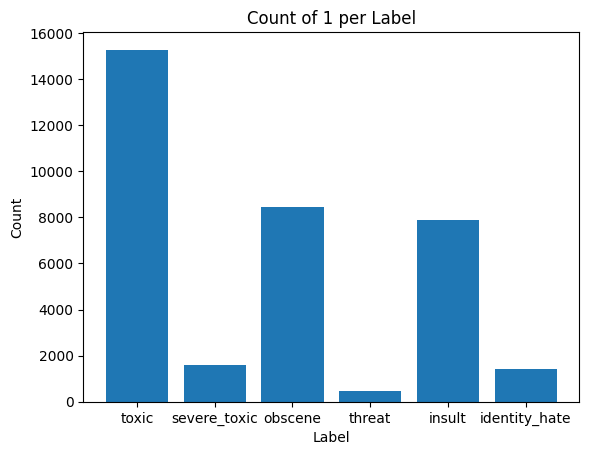

In [19]:
import matplotlib.pyplot as plt

labels = label_cols
count_1 = train_data[label_cols].sum().values

# Creating the bar chart
fig, ax = plt.subplots()
x = range(len(labels))

rects1 = ax.bar(x, count_1)

# Adding labels and title
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Count of 1 per Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Displaying the chart
plt.show()


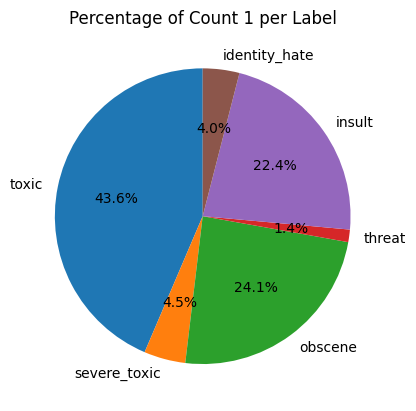

In [20]:
import matplotlib.pyplot as plt

labels = label_cols
count_1 = train_data[label_cols].sum().values

# Creating the pie chart
fig, ax = plt.subplots()

ax.pie(count_1, labels=labels, autopct='%1.1f%%', startangle=90)

# Adding title
ax.set_title('Percentage of Count 1 per Label')

# Displaying the chart
plt.show()


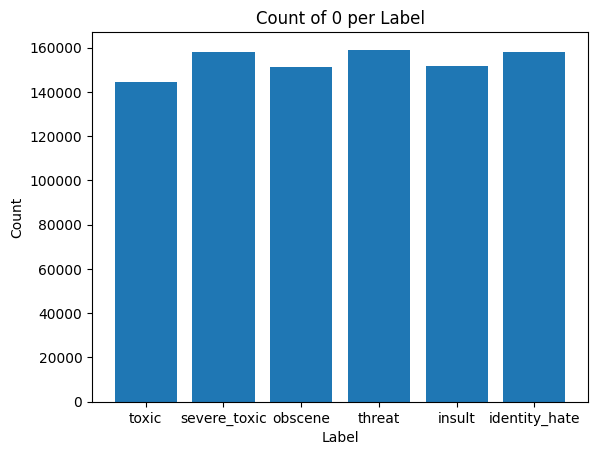

In [21]:
import matplotlib.pyplot as plt

labels = label_cols
count_0 = train_data[label_cols].eq(0).sum().values

# Creating the bar chart
fig, ax = plt.subplots()
x = range(len(labels))

rects1 = ax.bar(x, count_0)

# Adding labels and title
ax.set_xlabel('Label')
ax.set_ylabel('Count')
ax.set_title('Count of 0 per Label')
ax.set_xticks(x)
ax.set_xticklabels(labels)

# Displaying the chart
plt.show()


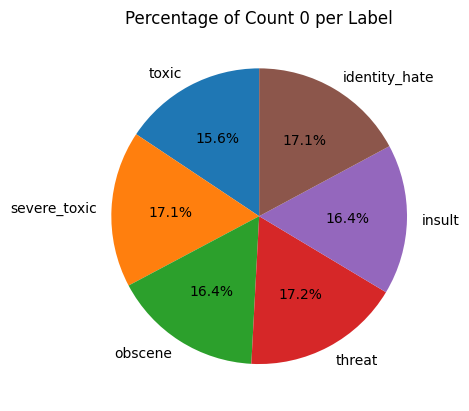

In [22]:
import matplotlib.pyplot as plt

labels = label_cols
count_0 = train_data[label_cols].eq(0).sum().values

# Creating the pie chart
fig, ax = plt.subplots()

ax.pie(count_0, labels=labels, autopct='%1.1f%%', startangle=90)

# Adding title
ax.set_title('Percentage of Count 0 per Label')

# Displaying the chart
plt.show()


In [23]:
df = train_data.sample(frac=1).reset_index(drop=True) #shuffle rows

In [24]:
df['labels'] = list(df[label_cols].values)
df.head(100)

,preprocessed_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,labels
0,photo additional photo andor photo upload need...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,hinduism personal people ok maybe make inflamm...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
2,look like vandalism probably wasntand fail dis...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
3,oh serious heartattack,1,0,0,0,0,0,"[1, 0, 0, 0, 0, 0]"
4,say page way much,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
95,one thing john please make personal attack lr ...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
96,block continue evade block userlilk ive explai...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
97,dynamoaces talk page archive message recived t...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
98,hadith regard traditional islamic school juris...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [36]:
labels = list(df.labels.values)
comments = list(df.preprocessed_text.values)

In [37]:
max_length = 128
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) # tokenizer

# Convert the list of integers to a list of strings
comments_as_strings = [str(comment) for comment in comments]

encodings = tokenizer.batch_encode_plus(comments_as_strings,max_length=max_length,pad_to_max_length=True) # tokenizer's encoding method

print('tokenizer outputs: ', encodings.keys())

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])


In [38]:
input_ids = encodings['input_ids'] # tokenized and encoded sentences
token_type_ids = encodings['token_type_ids'] # token type ids
attention_masks = encodings['attention_mask'] # attention masks

In [39]:
# Identifying indices of 'one_hot_labels' entries that only occur once - this will allow us to stratify split our training data later
label_counts = df.labels.astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()
one_freq_idxs = sorted(list(df[df.labels.astype(str).isin(one_freq)].index), reverse=True)
print('df label indices with only one instance: ', one_freq_idxs)

df label indices with only one instance:  [73852, 31461]


In [40]:
# Gathering single instance inputs to force into the training set after stratified split
one_freq_input_ids = [input_ids.pop(i) for i in one_freq_idxs]
one_freq_token_types = [token_type_ids.pop(i) for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels = [labels.pop(i) for i in one_freq_idxs]

Be sure to handle all classes during validation using "stratify" during train/validation split:

In [41]:
# Use train_test_split to split our data into train and validation sets

train_inputs, validation_inputs, train_labels, validation_labels, train_token_types, validation_token_types, train_masks, validation_masks = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                                                            random_state=2020, test_size=0.20, stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
train_labels = torch.tensor(train_labels)
train_masks = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

validation_inputs = torch.tensor(validation_inputs)
validation_labels = torch.tensor(validation_labels)
validation_masks = torch.tensor(validation_masks)
validation_token_types = torch.tensor(validation_token_types)

<ipython-input-41-170df11ba30a>:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  train_labels = torch.tensor(train_labels)


In [42]:
# We will use 32 here to avoid memory issues.
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels, train_token_types)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels, validation_token_types)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [43]:
torch.save(validation_dataloader,'validation_data_loader')
torch.save(train_dataloader,'train_data_loader')

## Load Model & Set Params

In [44]:
# Load model, the pretrained model will include a single linear classification layer on top for classification.
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=num_labels)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly i

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [45]:
# setting custom optimization parameters. You may implement a scheduler here as well.
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [47]:
from transformers import AdamW

optimizer = AdamW(optimizer_grouped_parameters,lr=2e-5,correct_bias=True)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## Train Model

In [48]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 1

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training

  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Tracking variables
  tr_loss = 0 #running loss
  nb_tr_examples, nb_tr_steps = 0, 0

  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss()
    loss = loss_func(logits.view(-1,num_labels),b_labels.type_as(logits).view(-1,num_labels)) #convert labels to float for calculation
    train_loss_set.append(loss.item())

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(validation_dataloader):
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch
    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Train loss: 0.054792386334988154


Epoch: 100%|██████████| 1/1 [44:53<00:00, 2693.01s/it]

F1 Validation Accuracy:  77.2914379802415
Flat Validation Accuracy:  92.05991101084163


In [49]:
import os

output_dir = os.path.expanduser('/content/drive/MyDrive/finetuned_bert')

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print('Saved')

Saved
